# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('../../data/datasets/action_images_dataset_original_v1.0')):
    X, y = load_data('../../data/datasets/action_images_dataset_original_v1.0', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 2038, Forehands count: 2412, Other count: 6217, Serve count: 1634
All strokes count: 12301


In [ ]:
## Uncomment and run this cell with the desired num_examples count
## if you'd like to work with less data for testing purposes

# num_examples = 500
# X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=num_examples, stratify=y, random_state=42)
# X = X_sampled
# y = y_sampled

# bh_cnt = sum([1 for l in y if l == 'backhand'])
# fh_cnt = sum([1 for l in y if l == 'forehand'])
# other_cnt = sum([1 for l in y if l == 'other'])
# serve_cnt = sum([1 for l in y if l == 'serve'])
# print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
# print(f'All strokes count: {len(y)}')

## Isprobavanje logističke regresije

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

`saga` rešavač najčešće izbacuje upozorenje da je moguće nastaviti treniranje, međutim isprobane su razne opcije i nisu postignuti bolji rezultati na validacionom skupu `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge "the coef_ did not converge", ConvergenceWarning)`, tako da je ostavljeno svuda `max_iter=100` da se ne gubi vreme nepotrebno.

In [8]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=7, max_iter=100)#, n_jobs=50)
clf.fit(X_train, y_train)

/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, n_jobs=50, penalty='l1', random_state=7,
                   solver='saga')

In [9]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [10]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.7765356820234869
Precision: 0.7604787345890072
Recall: 0.7396501421741017
F1 Score: 0.747177628194078

Validation set scores:
Accuracy: 0.7615176151761518
Precision: 0.7347279195730523
Recall: 0.7111138354349215
F1 Score: 0.7180752985359858


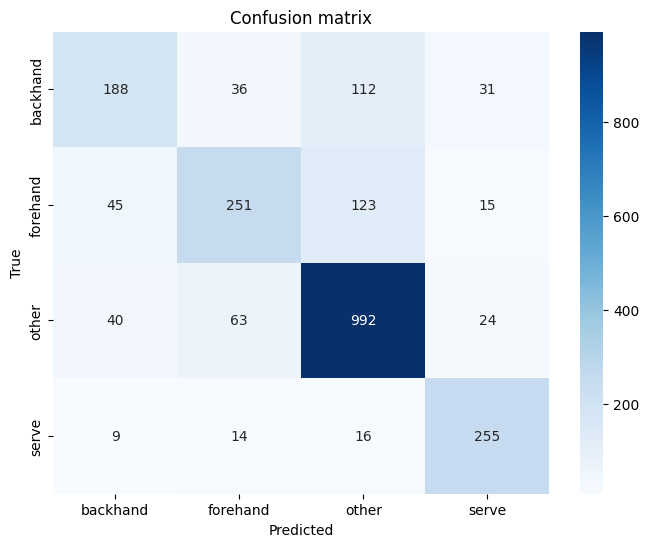

In [11]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.70      0.58      0.63      1467
    forehand       0.70      0.61      0.65      1737
       other       0.80      0.87      0.84      4476
       serve       0.84      0.89      0.86      1176

    accuracy                           0.78      8856
   macro avg       0.76      0.74      0.75      8856
weighted avg       0.77      0.78      0.77      8856



In [13]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.67      0.51      0.58       367
    forehand       0.69      0.58      0.63       434
       other       0.80      0.89      0.84      1119
       serve       0.78      0.87      0.82       294

    accuracy                           0.76      2214
   macro avg       0.73      0.71      0.72      2214
weighted avg       0.75      0.76      0.75      2214



## Pronalaženje najboljih hiperparametara

In [14]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [16]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = [
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [10**i for i in range(-3, 8)],
        'logreg__solver': ['saga'],
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__C': [10**i for i in range(-5, 5)],
        'logreg__solver': ['saga'],
        'logreg__l1_ratio': [0.0, 0.1, 0.2, 0.5, 0.9, 1]  # only used for elasticnet
    }
]

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('logreg', LogisticRegression(max_iter=100, random_state=42))])

Prvo se vrši pretraga prostora za parametre bez opcije `elastic_net`, a onda koristeći `elastic_net` i samo u tom slučaju smisleni `l1_ratio`.

### Analiza hiperparametara bez `elastic_net`-a

In [17]:
start = time.time()

grid_params_0 = GridSearchCV(grid_model, param_grid=params[0], scoring='f1_macro', verbose=True,
                             cv=kf, return_train_score=True)#, n_jobs=50)
grid_params_0.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 22 candidates, totalling 66 fits
Time taken: 00:01:12.02


/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
best_model = grid_params_0.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_0.best_score_}")
print(f"Best parameters: {grid_params_0.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7382891629063666
Best parameters: {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}

Training set scores:
Accuracy: 0.7929369918699187
Precision: 0.781355124494801
Recall: 0.7624878085157201
F1 Score: 0.7694790216774082

Validation set scores:
Accuracy: 0.8003048780487805
Precision: 0.7752935670524167
Recall: 0.7692273096533446
F1 Score: 0.7710945898876934


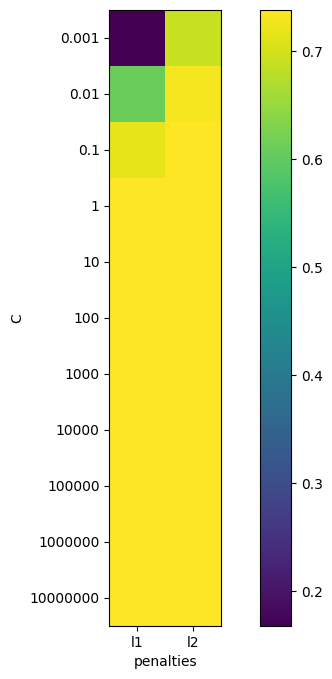

In [19]:
Cs = params[0]['logreg__C']
penalties = params[0]['logreg__penalty']

cv_results = pd.DataFrame(grid_params_0.cv_results_)
cv_test_score = cv_results['mean_test_score'].values.reshape(len(Cs), len(penalties))

plt.figure(figsize=(10, 8))

plt.ylabel('C')
plt.yticks(np.arange(0, len(Cs)), Cs)

plt.xlabel('penalties')
plt.xticks(np.arange(0, len(penalties)), penalties)

plt.imshow(cv_test_score, cmap='viridis')
plt.colorbar()
plt.show()

Iterativni proces određivanja hiperparametara nije navođen, već su međukoraci brisani, kako se ne bi zatrpavala sveska. Tako da su odabrani najbolji parametri iz prvog pokretanja `{'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}`. Videćemo koji rezultat daje sledeći skup parametara gde će se koristiti elastic_net, pa ćemo odabrati konačan skup parametara za treniranje modela nad početnim trening i validacionim skupom. Na kraju, ocenićemo na test skupu.

### Analiza hiperparametara sa `elastic_net`-om

In [20]:
start = time.time()

grid_params_1 = GridSearchCV(grid_model, param_grid=params[1], scoring='f1_macro', verbose=True,
                             cv=kf, return_train_score=True)#, n_jobs=50)
grid_params_1.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Time taken: 00:02:25.87


/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
best_model = grid_params_1.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_1.best_score_}")
print(f"Best parameters: {grid_params_1.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7382891629063666
Best parameters: {'logreg__C': 10, 'logreg__l1_ratio': 0.0, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}

Training set scores:
Accuracy: 0.7929369918699187
Precision: 0.781355124494801
Recall: 0.7624878085157201
F1 Score: 0.7694790216774082

Validation set scores:
Accuracy: 0.8003048780487805
Precision: 0.7752935670524167
Recall: 0.7692273096533446
F1 Score: 0.7710945898876934


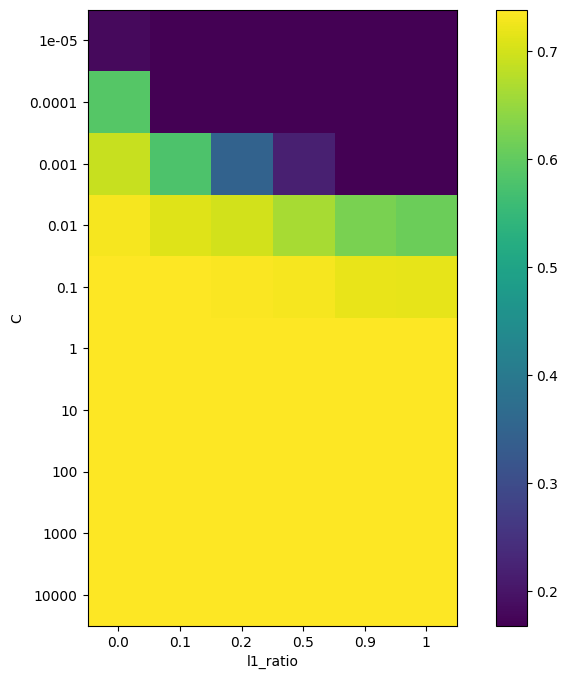

In [22]:
Cs = params[1]['logreg__C']
l1_ratios = params[1]['logreg__l1_ratio']

cv_results = pd.DataFrame(grid_params_1.cv_results_)
cv_test_score = cv_results['mean_test_score'].values.reshape(len(Cs), len(l1_ratios))

plt.figure(figsize=(10, 8))

plt.ylabel('C')
plt.yticks(np.arange(0, len(Cs)), Cs)

plt.xlabel('l1_ratio')
plt.xticks(np.arange(0, len(l1_ratios)), l1_ratios)

plt.imshow(cv_test_score, cmap='viridis')
plt.colorbar()
plt.show()

Ovo je ujedno i konačni kvalitet modela, kao i najbolji model dobijen ugnježdenom unakrsnom validacijom. U nastavku ćemo trenirati sa tim parametrima i proceniti kako radi na test skupu. Neće biti treniran model nad svim podacima iz skupa (uključujući i test), nego će biti eksportovana verzija trenirana nad trening i validacionim skupom da bi se prilikom demonstracije ili bilo kog daljeg koraka mogli koristiti primeri iz test skupa i dobijala relevantna predviđanja.

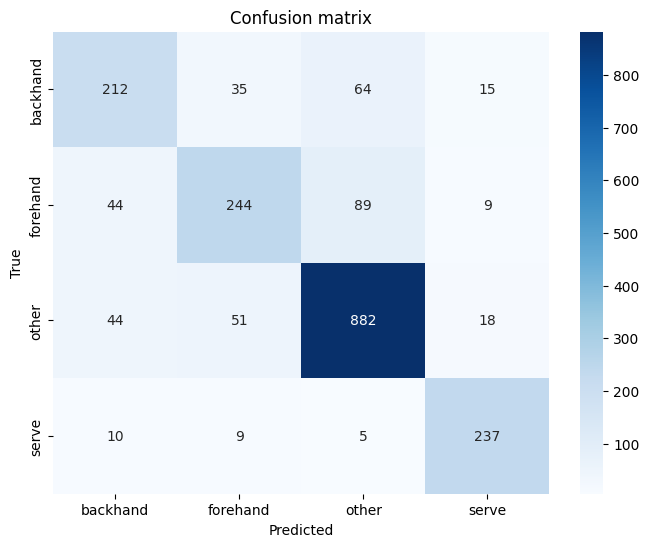

In [23]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.73      0.60      0.66      1304
    forehand       0.72      0.65      0.68      1544
       other       0.81      0.88      0.84      3978
       serve       0.86      0.92      0.89      1046

    accuracy                           0.79      7872
   macro avg       0.78      0.76      0.77      7872
weighted avg       0.79      0.79      0.79      7872



In [25]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.68      0.65      0.67       326
    forehand       0.72      0.63      0.67       386
       other       0.85      0.89      0.87       995
       serve       0.85      0.91      0.88       261

    accuracy                           0.80      1968
   macro avg       0.78      0.77      0.77      1968
weighted avg       0.80      0.80      0.80      1968



Možemo videti da model već sada ne generalizuje baš najbolje, videćemo šta će tek biti na test skupu, ali ipak, rezultati su korektni s obzirom na jednostavnost korišćenog modela i ne baš malu kompleksnost podataka (a i loše su labelirani u ovom slučaju). Ipak, vidimo da je model prilično dobro naučio da prepozna klase `other` i `serve`, a da se muči s klasama `forehand` i `backhand`, što se donekle može i očekivati, ako se posmatra relativna sličnost ovih udaraca, ali i potencijalni broj pogrešno labeliranih primeraka ove klase, jer se ovi udarci javljaju usred relija, te je veća šansa da oni budu zamenjeni.

## Procena modela na test skupu

In [26]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.7842340511986997
Precision: 0.766298366321669
Recall: 0.7541464098932354
F1 Score: 0.7589236312985994


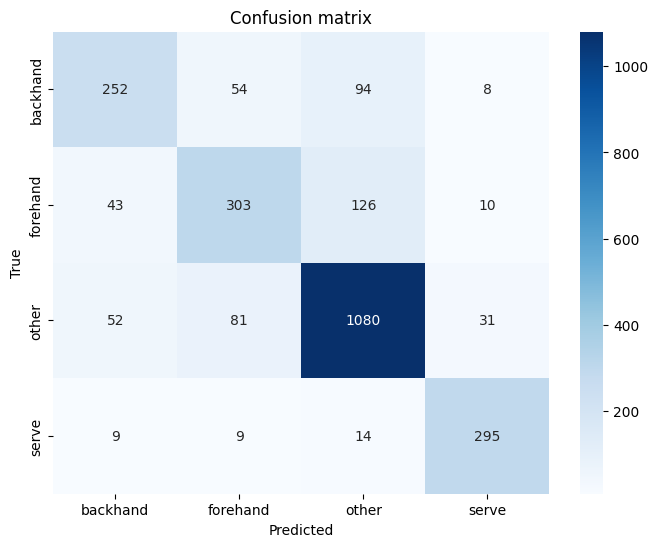

In [27]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.71      0.62      0.66       408
    forehand       0.68      0.63      0.65       482
       other       0.82      0.87      0.84      1244
       serve       0.86      0.90      0.88       327

    accuracy                           0.78      2461
   macro avg       0.77      0.75      0.76      2461
weighted avg       0.78      0.78      0.78      2461



Na kraju, vidimo da nismo praktično odmakli od inicijalnog modela, koji je kreiran nasumičnim probanjem parametara. Ipak, raduje to što dobijamo slične rezultate za test set, kao i za validacioni. Ovo je ujedno i konačan model, koji ćemo sačuvati za kasniju upotrebu.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [29]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/00_logistic_regression_original_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)